In [1]:
data_explanation = {"CHANNEL": "Channel used to send the packet",
"CODR" : "Coding rate packet",
"CREATED AT": "Timestamp indicating the time when the entry has been created inside the database",
"DATR" :"SF and bandwidth of the packet",
"DEV_ADDR" :"Unique identifier of the device inside the network",
"DEV_EUI" : "Unique identifier of the physical device (None if the device is unknown)",
"FREQUENCY" : "Frequency of the sent packet in MHz",
"GATEWAY" : "GW MAC ADDRESS which received the packet",
"LSNR" : "Received signal to noise ratio of the packet",
"FCNT" : "Frame counter: counter increasing for each packet sent from ED;used evaluate error rate",
"RSSI" : "Received packet signal strength",
"SIZE" : "Packet size (bytes)",
"CRC_STATUS" : "result: if 1 = passed if −1 = failed",
"TMST" : "Internal clock timestamp from gateway: used for synchronizing the downlink\
        with the end transmission of the uplink to communicate response to end-device",
"UID" : "Unique identifier of the entry inside the database}"}

In [2]:
import pandas as pd
import math
import numpy as np
import csv
import matplotlib.pyplot as plt

In [65]:
# clustering methods and metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import davies_bouldin_score

In [3]:
data = pd.read_csv("anonymized_spazio_radio_v2.csv")

In [4]:
def countna():
    nasdict = {}
    for i in data.columns:
        nasdict[i] = [('not na', data[i].notna().sum()),('na', data[i].isna().sum())]
    return nasdict

In [5]:
countna()

{'ant': [('not na', 186632), ('na', 0)],
 'chan': [('not na', 186632), ('na', 0)],
 'codr': [('not na', 186632), ('na', 0)],
 'created_at': [('not na', 186632), ('na', 0)],
 'datr': [('not na', 186632), ('na', 0)],
 'dev_addr': [('not na', 186632), ('na', 0)],
 'dev_eui': [('not na', 186632), ('na', 0)],
 'dev_nonce': [('not na', 5106), ('na', 181526)],
 'freq': [('not na', 186632), ('na', 0)],
 'gateway': [('not na', 186632), ('na', 0)],
 'lsnr': [('not na', 186632), ('na', 0)],
 'ns_time': [('not na', 186632), ('na', 0)],
 'rssi': [('not na', 181526), ('na', 5106)],
 'rssic': [('not na', 186632), ('na', 0)],
 'rssis': [('not na', 176025), ('na', 10607)],
 'rssisd': [('not na', 176025), ('na', 10607)],
 'size': [('not na', 186632), ('na', 0)],
 'time': [('not na', 186622), ('na', 10)],
 'tmms': [('not na', 186622), ('na', 10)],
 'tmst': [('not na', 186632), ('na', 0)],
 'FCnt': [('not na', 181526), ('na', 5106)],
 'valueRaw': [('not na', 186632), ('na', 0)],
 'value_minutes': [('not n

# Analyzing Na's
First observation is the variable dev_nonce has more than 90% Na's
rssis and rssisd have similar number of Na's, and the same thing with time and tmms
rssi and fcnt also have the same number of Nas

## We compare the na values in the rows to make sure that the similar number of nas across variables refer to the same rows

In [6]:
def nas():
    col = data.columns.tolist()
    matchingna = []
    for i in col:
        col.remove(i)
        for j in col:
            if (data.loc[pd.isna(data[i]) == True, :].index.tolist() == data.loc[pd.isna(data[j]) == True, :].index.tolist())\
            and len(data.loc[pd.isna(data[i]) == True, :].index.tolist()) != 0 :
                matchingna.append((i,j))
    return matchingna

In [7]:
nas()

[('rssi', 'FCnt'), ('rssis', 'rssisd'), ('tmms', 'time')]

# After making sure of the number of Na's we can drop all the Na's knowing that it won't have a major effect on the population size

In [8]:
data = data.drop(columns = ['dev_nonce'])

In [9]:
data = data.dropna()

In [10]:
data = data.drop(columns = ['ns_time']) #we drop ns_time because
                                        #the time of inserting the data inside the database is not relavant to our analysis
data = data.drop(columns = ['created_at','tmms','value_minutes','tmst',])    

In [11]:
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.tz_convert(None)

In [12]:
data.time = (data.time - pd.to_datetime('1970-01-01')).dt.total_seconds().astype(int)

In [13]:
data.head()

,ant,chan,codr,datr,dev_addr,dev_eui,freq,gateway,lsnr,rssi,rssic,rssis,rssisd,size,time,FCnt,valueRaw
0,1,23,4/5,SF12BW125,000000ff,00000000000000ff,868.5,7276FF002E061495,-18.0,-108.0,-108,-126.0,0.0,64,1547648565,190.0,1547648566
1,0,6,4/5,SF12BW125,00000043,0000000000000043,868.3,7276FF002E061495,12.0,-93.0,-93,-93.0,0.0,64,1547649172,149.0,1547649173
2,1,23,4/5,SF12BW125,00000013,0000000000000013,868.5,7276FF002E061495,14.0,-90.0,-90,-90.0,0.0,64,1547650148,207.0,1547650149
3,1,21,4/5,SF12BW125,00000117,0000000000000117,868.1,7276FF002E061495,-20.0,-108.0,-108,-129.0,0.0,64,1547656287,99.0,1547656289
4,1,21,4/5,SF12BW125,00000055,0000000000000055,868.1,7276FF002E061495,-6.0,-107.0,-107,-115.0,0.0,64,1547656731,161.0,1547656732


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171198 entries, 0 to 186631
Data columns (total 17 columns):
ant         171198 non-null int64
chan        171198 non-null int64
codr        171198 non-null object
datr        171198 non-null object
dev_addr    171198 non-null object
dev_eui     171198 non-null object
freq        171198 non-null float64
gateway     171198 non-null object
lsnr        171198 non-null float64
rssi        171198 non-null float64
rssic       171198 non-null int64
rssis       171198 non-null float64
rssisd      171198 non-null float64
size        171198 non-null int64
time        171198 non-null int32
FCnt        171198 non-null float64
valueRaw    171198 non-null int64
dtypes: float64(6), int32(1), int64(5), object(5)
memory usage: 22.9+ MB


In [15]:
for col in data.columns:
    if data[col].dtypes == ('O'):
        print(col)

codr
datr
dev_addr
dev_eui
gateway


In [16]:
data = pd.get_dummies(data)

In [17]:
data.head()

,ant,chan,freq,lsnr,rssi,rssic,rssis,rssisd,size,time,...,dev_eui_000000000000011a,dev_eui_000000000000011b,dev_eui_000000000000011c,dev_eui_000000000000011d,dev_eui_000000000000011e,dev_eui_000000000000011f,dev_eui_0000000000000120,dev_eui_0000000000000121,gateway_7276FF002E050264,gateway_7276FF002E061495
0,1,23,868.5,-18.0,-108.0,-108,-126.0,0.0,64,1547648565,...,0,0,0,0,0,0,0,0,0,1
1,0,6,868.3,12.0,-93.0,-93,-93.0,0.0,64,1547649172,...,0,0,0,0,0,0,0,0,0,1
2,1,23,868.5,14.0,-90.0,-90,-90.0,0.0,64,1547650148,...,0,0,0,0,0,0,0,0,0,1
3,1,21,868.1,-20.0,-108.0,-108,-129.0,0.0,64,1547656287,...,0,0,0,0,0,0,0,0,0,1
4,1,21,868.1,-6.0,-107.0,-107,-115.0,0.0,64,1547656731,...,0,0,0,0,0,0,0,0,0,1


In [18]:
data_vals=data.iloc[:, :].values
data_vals

array([[  1. ,  23. , 868.5, ...,   0. ,   0. ,   1. ],
       [  0. ,   6. , 868.3, ...,   0. ,   0. ,   1. ],
       [  1. ,  23. , 868.5, ...,   0. ,   0. ,   1. ],
       ...,
       [  0. ,   7. , 868.5, ...,   0. ,   0. ,   1. ],
       [  1. ,  22. , 868.3, ...,   0. ,   0. ,   1. ],
       [  0. ,   5. , 868.1, ...,   0. ,   1. ,   0. ]])

## Computes the Davies-Bouldin and Within-Cluster-Sum-of-Squares (WCSS) scores

In [69]:
wcss=[]
dbs=[]
for i in range(2,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 ).fit(data_vals)
#inertia_ : Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    dbs.append(davies_bouldin_score(data_vals, labels))
    print('clustering with k = {} done!'.format(i))

In [70]:
dbs

[0.5023866983800407,
 0.5200890502213479,
 0.5049245776405188,
 0.49052258140824634,
 0.48431135667898784,
 0.47432659536378263,
 0.4791715966102152,
 0.484216860820574,
 0.495747215518829]

In [28]:
wcss

[2.665678553936232e+19,
 6.756687348563645e+18,
 3.078729058432763e+18,
 1.7128467138792827e+18,
 1.0582116038675674e+18,
 6.996803073306802e+17,
 4.9267677951677203e+17,
 3.91948492074051e+17,
 3.095452600170082e+17,
 2.5176351165732736e+17]

#### We can find the optimum value for K using an Elbow point and Davies-Bouldin graph.

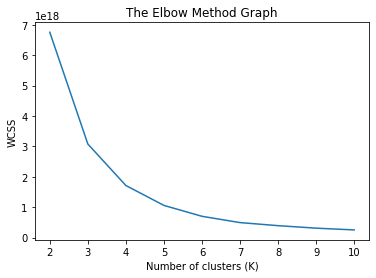

In [77]:
#Plot the elbow graph
plt.plot(range(2,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

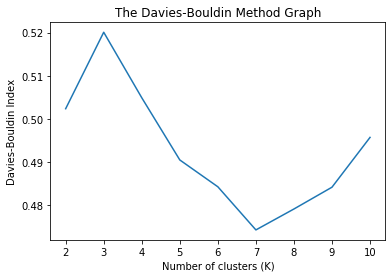

In [86]:
#Plot the Davies-Bouldin graph
plt.plot(range(2,11),dbs)
plt.title('The Davies-Bouldin Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [94]:
kmeans = KMeans(n_clusters=7, init ='k-means++', max_iter=300, n_init=10, random_state=0, n_jobs= -1 )

In [95]:
y_kmeans = kmeans.fit_predict(data_vals)

In [97]:
data_vals.shape

(171198, 601)

In [98]:
y_kmeans

array([0, 0, 0, ..., 2, 2, 2])